# AIN 214 - PA5 - 2023 on Clustering

This homework aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering, and explore the impact of PCA on these clustering techniques.



# Student Info
## Name Surname: Bora Dere
## Student ID: 2220765021


## Dataset

We will use the Mall Customer Segmentation Data from Kaggle. The dataset is added to the homework folder - also accessible at [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/).
 

## 1. Data Cleaning

* **Objective**: Prepare your dataset for analysis.
* **Tasks**: Handle missing values, encode categorical features, handle outliers.

The steps for data cleaning may vary. I do not expect you to use a spefisific algorithm to handle outliers for example. But **show your work!**


### Imports and loading the dataset

In [280]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# loading the data
data = pd.read_csv('Mall_Customers.csv')

In [281]:
df = pd.DataFrame(data)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [282]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There are no missing values. That is relieving.

ID column is unnecessary for clustering, so it is dropped.

In [283]:
df.drop(['CustomerID'], axis=1, inplace=True)

In [284]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### Outlier handling

In [285]:
# self plagiarism from my previous assignment


def outlier_finder(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    inner_lower_fence = Q1 - 1.5*IQR
    inner_upper_fence = Q3 + 1.5*IQR

    outer_lower_fence = Q1 - 3*IQR
    outer_upper_fence = Q3 + 3*IQR

    mild_outliers = [i for i in data if (i < inner_lower_fence and i > outer_lower_fence) or (i > inner_upper_fence and i < outer_upper_fence)]
    extreme_outliers = [i for i in data if i < outer_lower_fence or i > outer_upper_fence]

    return mild_outliers, extreme_outliers


def outlier_printer(outliers, feature):
    mild_outliers = outliers[0]
    extreme_outliers = outliers[1]
    
    if len(mild_outliers) != 0:
        # to achieve a better output format
        o1 = f"There are {len(mild_outliers)} mild outliers in the {feature} feature."
        o2 = f"{mild_outliers[0]} is a mild outlier for the {feature} feature."

        print(o1)
        print("-"*len(o1 if len(o1) > len(o2) else o2))
        
        for i in mild_outliers:
            print(f"{i} is a mild outlier for the {feature} feature.")

        print()

    if len(extreme_outliers) != 0:
        o1 = f"There are {len(extreme_outliers)} extreme outliers in the {feature} feature."
        o2 = f"{extreme_outliers[0]} is an extreme outlier for the {feature} feature."

        print(o1)
        print("-"*len(o1 if len(o1) > len(o2) else o2))
        
        for i in extreme_outliers:
            print(f"{i} is an extreme outlier for the {feature} feature.")

In [286]:
outliers_d = {}

for column in df.columns[1:]: # gender is not included for obvious reasons
    print(f"Outliers for {column}:")
    print("-"*len(f"Outliers for {column}:"))
    outliers = outlier_finder(df[column])
    outlier_printer(outliers, column)
    outliers_d[column] = outliers
    if column != df.columns[-1]:
        print("\n")

Outliers for Age:
-----------------


Outliers for Annual Income (k$):
--------------------------------
There are 2 mild outliers in the Annual Income (k$) feature.
------------------------------------------------------------
137 is a mild outlier for the Annual Income (k$) feature.
137 is a mild outlier for the Annual Income (k$) feature.



Outliers for Spending Score (1-100):
------------------------------------


Relatively small amount of outliers. It is expected, actually. This dataset is not likely to contain many outliers.

In [287]:
outlier_removed_df = df.copy()

for key, value in outliers_d.items():
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(value[1])]
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(value[0])]

outlier_removed_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,198.0,38.929293,14.016852,18.0,28.25,36.0,49.00,70.0
Annual Income (k$),198.0,59.787879,25.237259,15.0,40.50,61.0,77.75,126.0
Spending Score (1-100),198.0,50.196970,25.746846,1.0,35.00,50.0,72.75,99.0


Encoding gender as 1 and 0 since it is a binary variable.

In [288]:
d = {"Male": 1, "Female": 0}

outlier_removed_df.replace(d, inplace=True)

outlier_removed_df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
193,0,38,113,91
194,0,47,120,16
195,0,35,120,79
196,0,45,126,28


## 2. Data Preprocessing

* **Objective**: Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.

In [289]:
from sklearn.preprocessing import normalize

In [290]:
normalized_data = normalize(outlier_removed_df.iloc[:, 1:])
normalized_data = pd.DataFrame(normalized_data, columns=outlier_removed_df.columns[1:])

normalized_data.reset_index(drop=True, inplace=True)
outlier_removed_df.reset_index(drop=True, inplace=True)

normalized_data['Gender'] = outlier_removed_df['Gender']
normalized_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,198.0,0.440631,0.187714,0.181117,0.275244,0.399967,0.582250,0.957680
Annual Income (k$),198.0,0.628424,0.186510,0.176446,0.520912,0.643398,0.761613,0.971821
Spending Score (1-100),198.0,0.533416,0.238776,0.011583,0.420984,0.563491,0.680997,0.954967
Gender,198.0,0.434343,0.496927,0.000000,0.000000,0.000000,1.000000,1.000000


## 3. Dimensionality Reduction

### What is Dimensionality Reduction and Why is it Used?
Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### 3.1. Principal Component Analysis (PCA)
PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance.
**Process:**
* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.





### 3.2. Apply PCA
* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.

**Simply use the PCA from sklearn library**

In [291]:
from sklearn.decomposition import PCA

In [292]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

pca_data = pd.DataFrame(data = pca_data, columns = ['PC1', 'PC2'])
pca_data

,PC1,PC2
0,0.540839,0.442510
1,0.530461,0.647518
2,-0.411565,-0.371061
3,-0.466089,0.557146
4,-0.449253,0.250386
...,...,...
193,-0.438338,0.036498
194,-0.405486,-0.478195
195,-0.433339,-0.045131
196,-0.410822,-0.398785


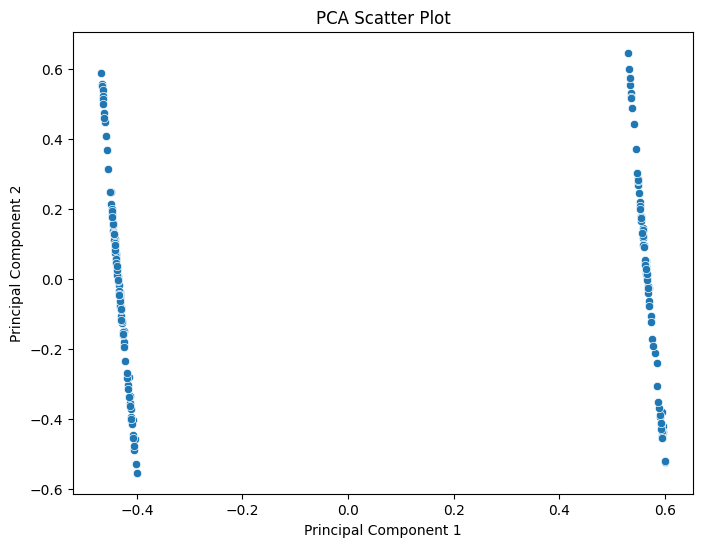

In [293]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_data, x='PC1', y='PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

Yes, it seems like there are some clusters but it is hard to specify, actually.

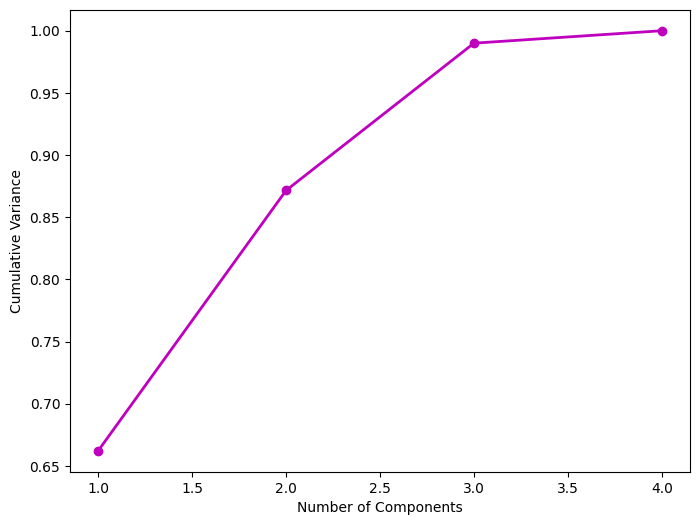

In [294]:
pca = PCA()
pca.fit_transform(normalized_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

components = np.arange(1, len(explained_variance) + 1)

plt.figure(figsize=(8, 6))
plt.plot(components, cumulative_variance, 'o-', linewidth=2, c='m')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.show()

The best n value seems to be 3.

In [295]:
from mpl_toolkits.mplot3d import Axes3D

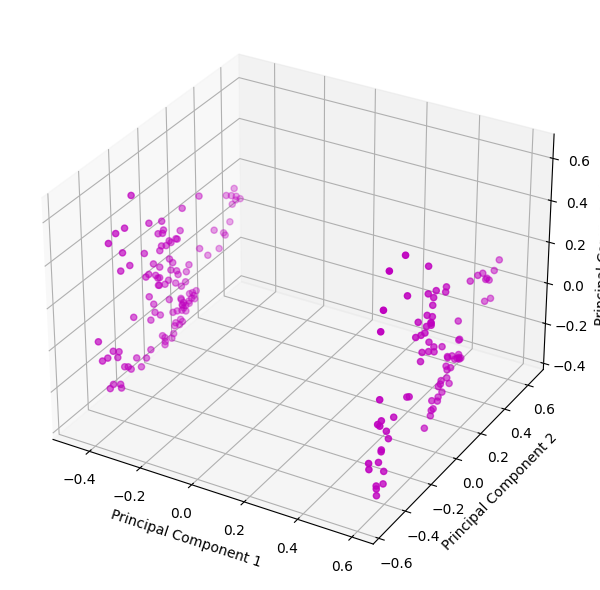

In [296]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(normalized_data)

pca_data = pd.DataFrame(data = pca_data, columns = ['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], color='m')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.tight_layout()
plt.show()

## 4. Clustering on the Original Dataset

### 4.1. K-Means Clustering on the Original Dataset

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

In [297]:
from sklearn.cluster import KMeans

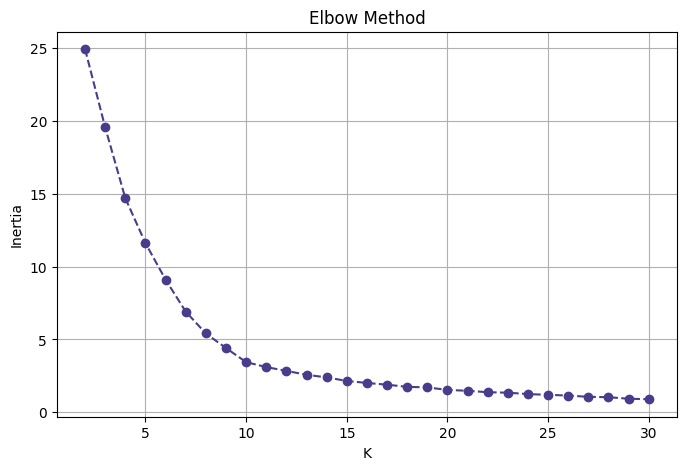

In [298]:
dist = []

for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(normalized_data)
    dist.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 31), dist, marker='o', color='darkslateblue', linestyle='dashed')
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

5 seems like a convenient k value.

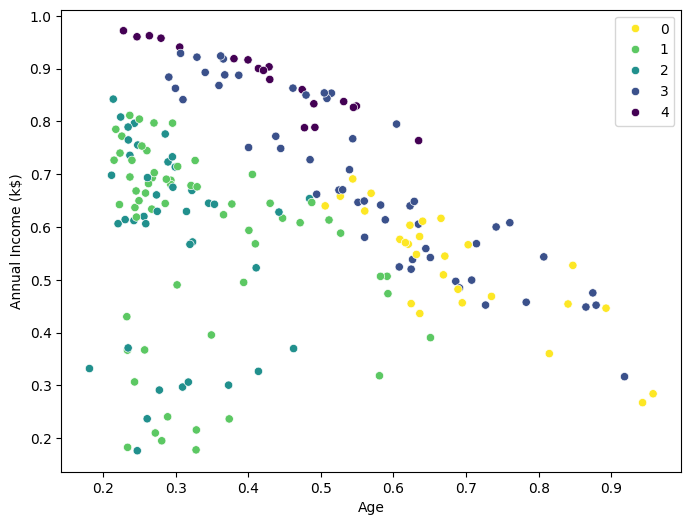

In [299]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(normalized_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=normalized_data, x='Age', y='Annual Income (k$)', hue=kmeans.labels_, palette='viridis_r')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show()

### 4.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

In [300]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

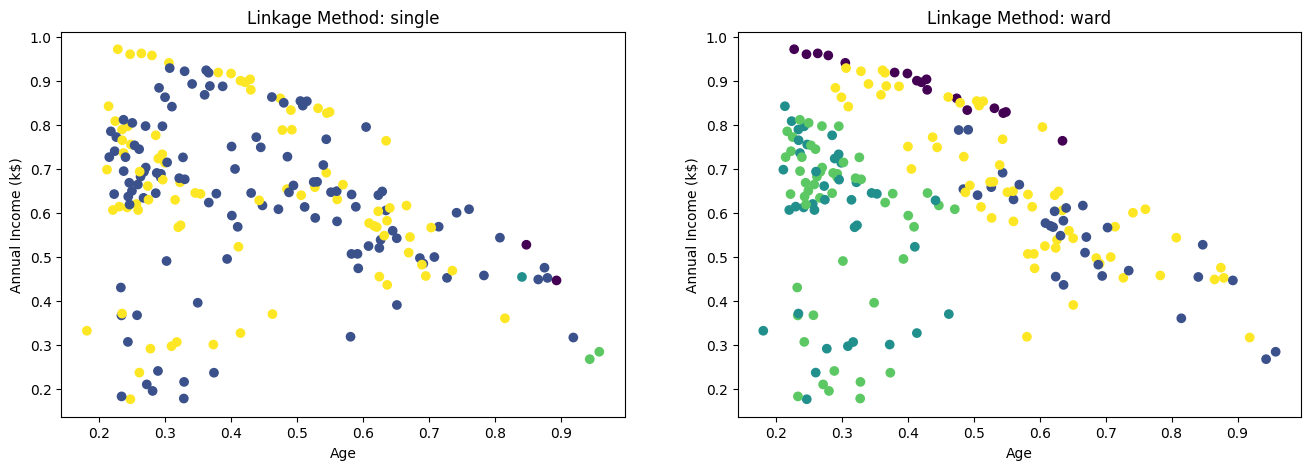

In [301]:
linkage_methods = ['single', 'ward']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for i, method in enumerate(linkage_methods):
    hac = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage=method)
    hac.fit(normalized_data)
    axes[i].scatter(normalized_data['Age'], normalized_data['Annual Income (k$)'], c=hac.labels_, cmap='viridis_r')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Annual Income (k$)')
    axes[i].set_title(f'Linkage Method: {method}')

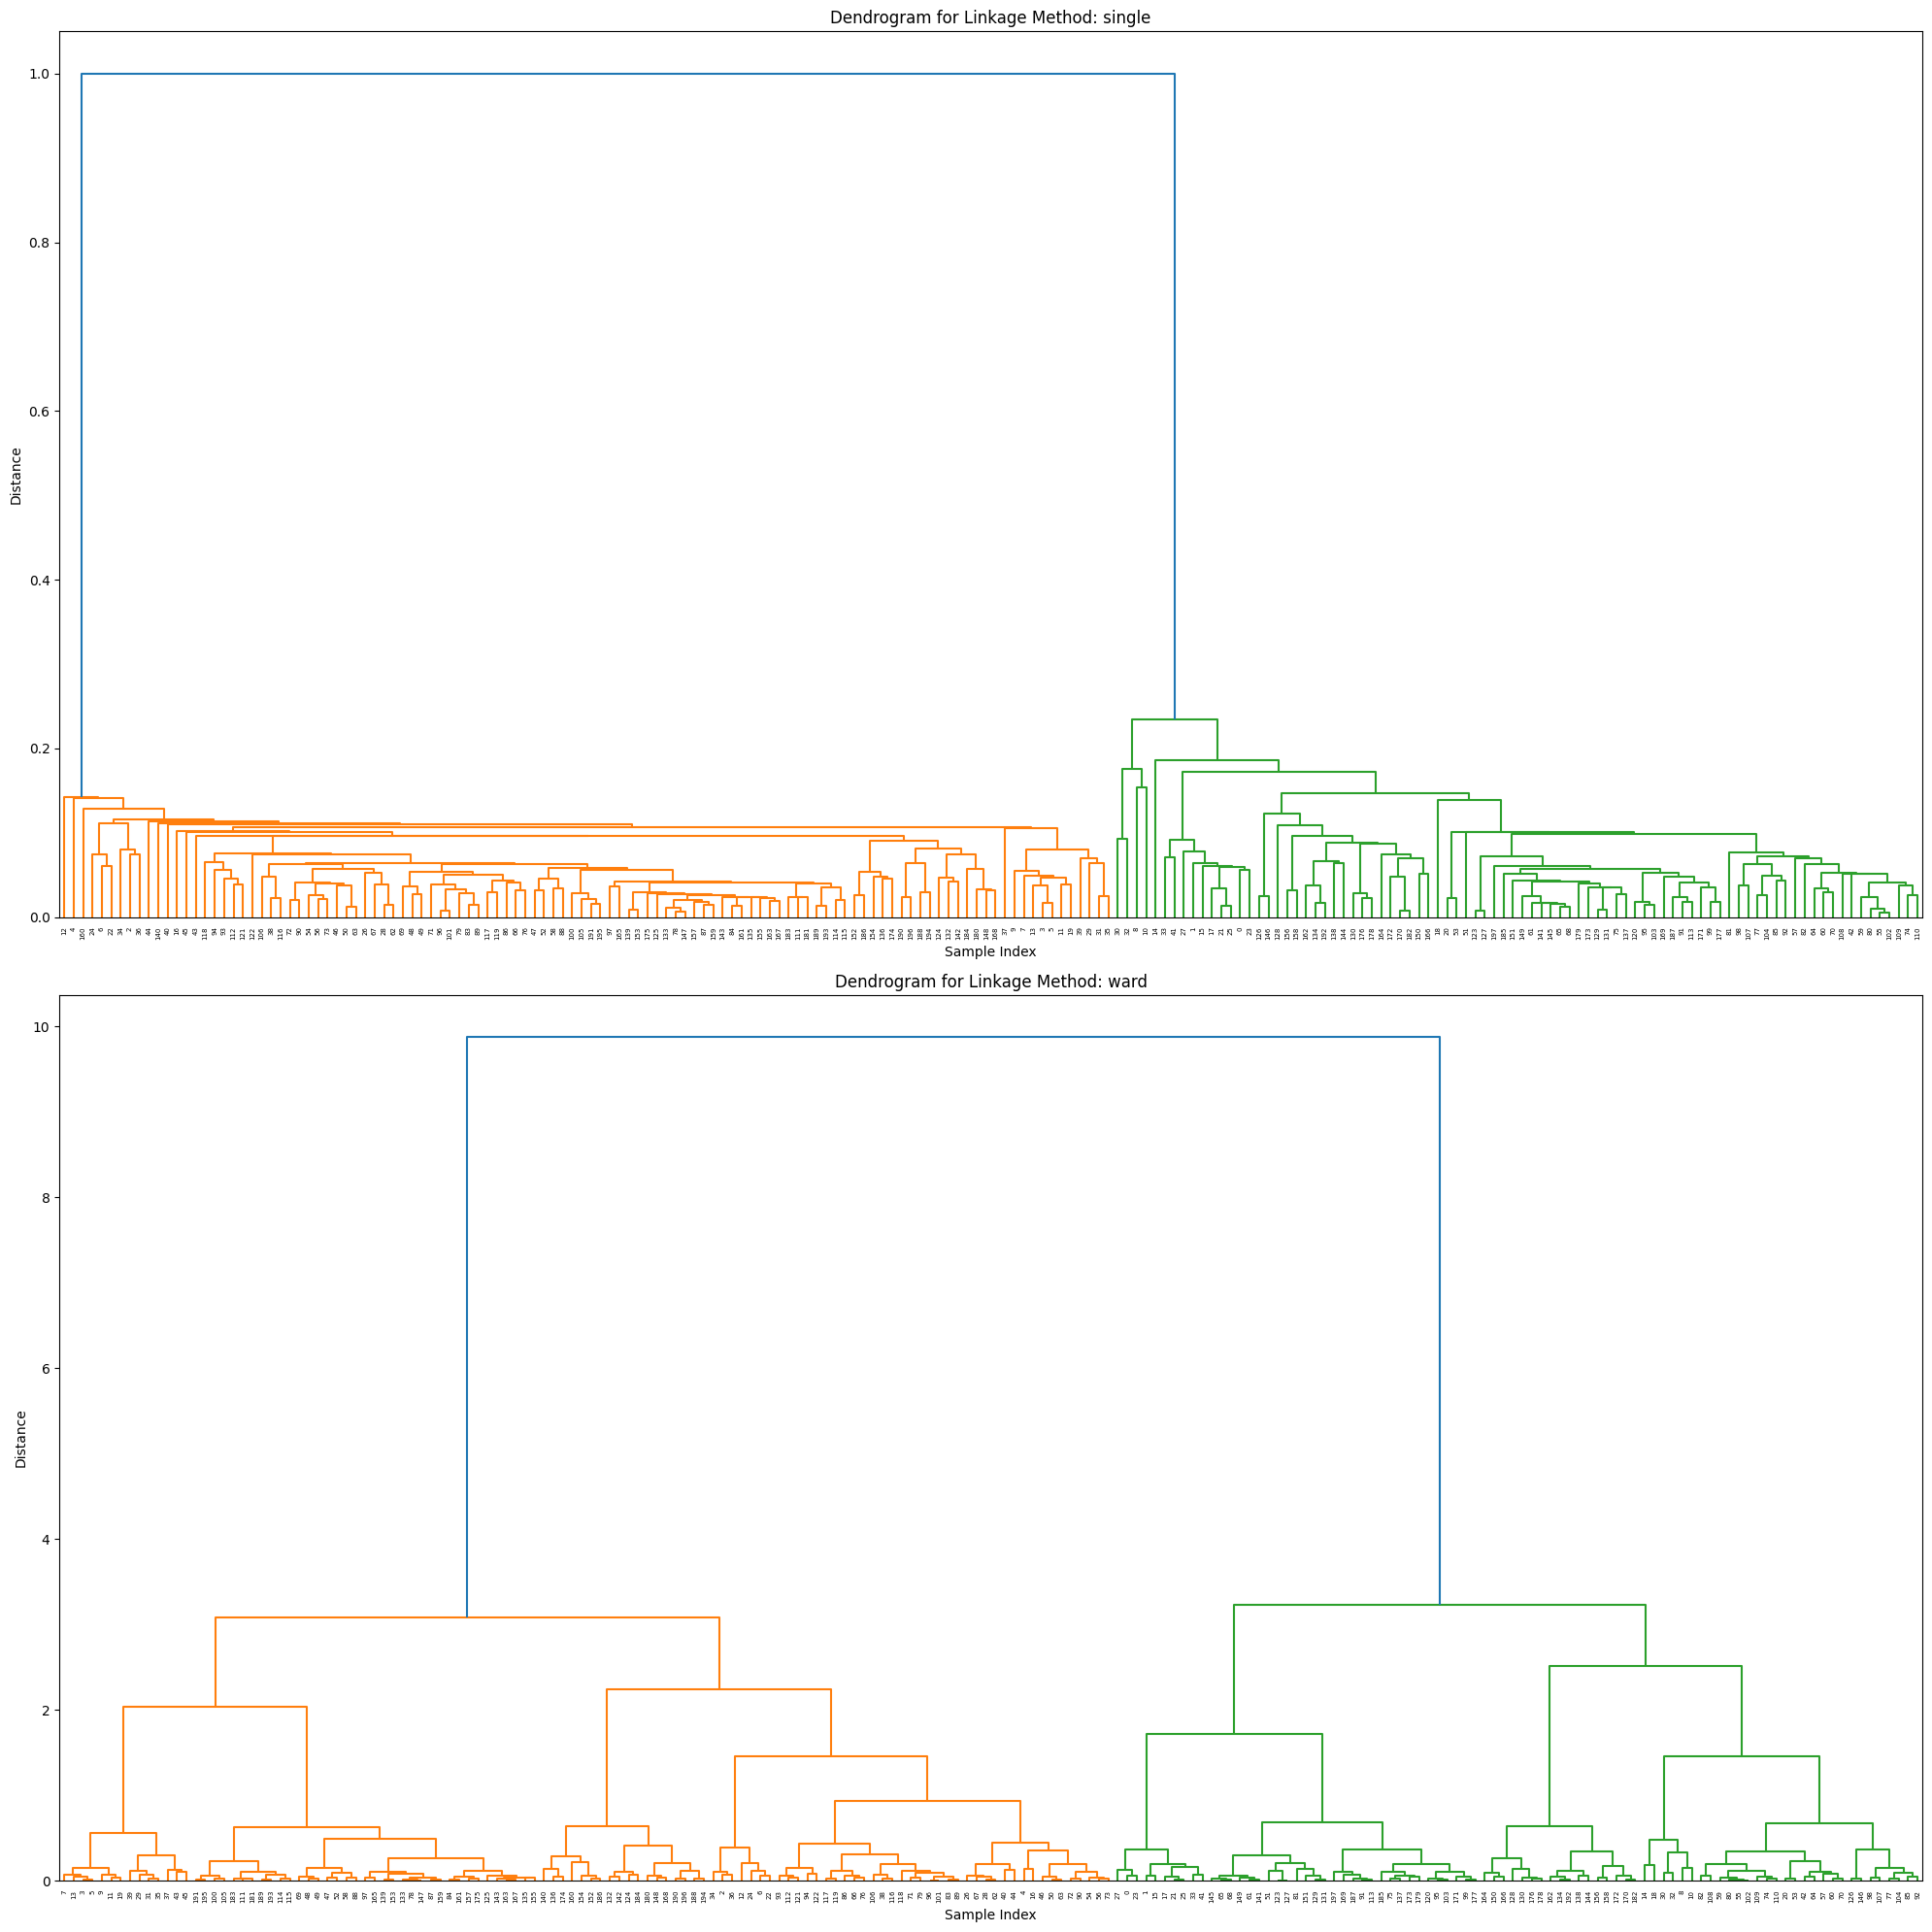

In [302]:
fig, axes = plt.subplots(2, 1, figsize=(20, 20))

for i, method in enumerate(linkage_methods):
    Z = linkage(normalized_data, method=method)
    axes[i].set_title(f'Dendrogram for Linkage Method: {method}')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Distance')
    dendrogram(Z, ax=axes[i])

plt.tight_layout()
plt.show()

For both methods, dendograms seem like they agree with the scatter plots.

## 5. K-means Clustering with PCA

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

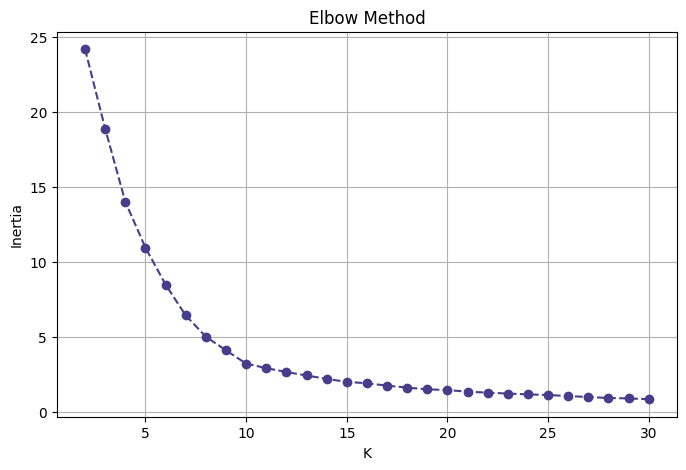

In [303]:
dist = []

for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pca_data)
    dist.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 31), dist, marker='o', color='darkslateblue', linestyle='dashed')
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

For PCA data, 5 seems like a good value.

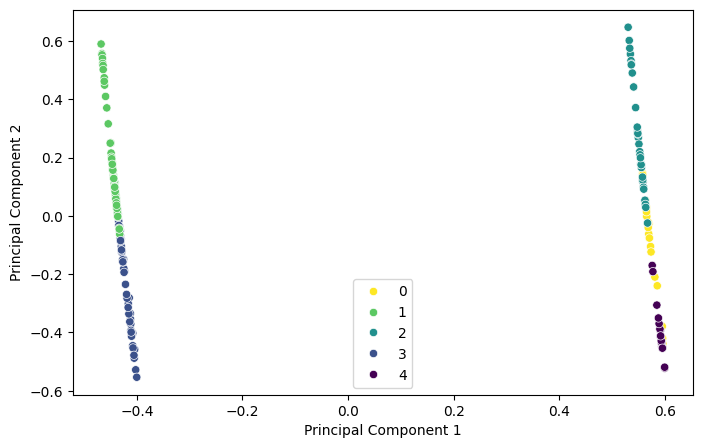

In [304]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(normalized_data)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue=kmeans.labels_, palette='viridis_r')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 6. Evaluate the Clustering Results

* Evaluate and compare the clustering results obtained in 4.1 and 5 (k means with and without PCA) using the Silhouette Coefficients.
* Which is better?

In [305]:
from sklearn.metrics import silhouette_score

In [306]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)

kmeans.fit(normalized_data)
score = silhouette_score(normalized_data, kmeans.labels_)
print(f"Silhouette Score for KMeans without PCA: {score}")

kmeans.fit(pca_data)
score = silhouette_score(pca_data, kmeans.labels_)
print(f"Silhouette Score for KMeans with PCA: {score}")

Silhouette Score for KMeans without PCA: 0.41568207268460694
Silhouette Score for KMeans with PCA: 0.4237762529372923


As can be seen from the silhouette scores, using PCA gives us better results.